In [1]:
import os
#list the current work dir
os.getcwd()
#change the current work dir
os.chdir('/home/siyuan/Seafile/Thesis/PycharmProjects/DD_PE_paper/')

In [2]:
from networkx.generators.random_graphs import erdos_renyi_graph
from src.QAOA.QAOA_approximation import generate_three_regular_graph, generate_graph_matrix, create_qaoa_circ, compute_expectation
from scipy.optimize import minimize
import numpy as np

In [3]:
from qiskit import IBMQ, transpile, Aer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='default')
backend = provider.get_backend('ibmq_toronto')

In [4]:
from src.tools.DD_insertion import pm_DD_sequences
from qiskit.transpiler import PassManager, InstructionDurations

durations = InstructionDurations.from_backend(backend)
pms = pm_DD_sequences(durations)

In [5]:
from src.QAOA.QAOA_approximation import get_ansatz_parm

In [6]:
##Construct 3-regular graphs of different degree
weight_matrices = []
graphs = []
circuits = []

for i in range(4, 13, 2):
    G = generate_three_regular_graph(i)
    res = get_ansatz_parm(G)
    print(res)
    qc = create_qaoa_circ(G, res.x)
    w = generate_graph_matrix(G)
    weight_matrices.append(w)
    graphs.append(G)
    circuits.append(qc)
    print('----------')

     fun: -3.693359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 33
  status: 1
 success: True
       x: array([52.12044927, 92.93027933])
----------
     fun: -5.3173828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 27
  status: 1
 success: True
       x: array([52.14027902, 93.93254817])
----------
     fun: -6.0341796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 33
  status: 1
 success: True
       x: array([50.97493708, 91.75939733])
----------
     fun: -9.2822265625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([51.43942058, 92.4067444 ])
----------
     fun: -9.5009765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35
  status: 1
 success: True
       x: array([52.1257119 , 92.94228148])
----------


In [7]:
## construct randomized graph of different degree
seed = 200
p = 0.5
for i in range(4, 13, 2):
    G = erdos_renyi_graph(i, p, seed)
    res = get_ansatz_parm(G)
    print(res)
    qc = create_qaoa_circ(G, res.x)
    w = generate_graph_matrix(G)
    weight_matrices.append(w)
    graphs.append(G)
    circuits.append(qc)
    print('----------')

     fun: -2.0634765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([51.48692938, 93.00036061])
----------
     fun: -6.861328125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([52.08505957, 92.89675027])
----------
     fun: -11.4970703125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([52.07542478, 92.83308516])
----------
     fun: -14.072265625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([49.79069762, 93.1481553 ])
----------
     fun: -19.521484375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35
  status: 1
 success: True
       x: array([52.12625061, 90.93369183])
----------


In [8]:
## add duration of y gates which are used for DD sequences
bconf = backend.configuration()
for i in range(bconf.num_qubits):
    x_duration = durations.get('x', i)
    durations.update(InstructionDurations(
        [('y', i, x_duration)]
        ))

    durations.update(InstructionDurations(
        [('rx', i, x_duration)]
        ))

    durations.update(InstructionDurations(
        [('ry', i, x_duration)]
        ))

In [9]:
# Template optimisation for RZZ gate and SWAP gate

from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib

# Transpiler passes
from qiskit.transpiler.passes import Collect2qBlocks
from qiskit.transpiler.passes import ConsolidateBlocks
from qiskit.transpiler.passes import Optimize1qGatesDecomposition
from qiskit.transpiler.passes.basis import BasisTranslator, UnrollCustomDefinitions
from qiskit.transpiler.passes.scheduling.calibration_creators import RZXCalibrationBuilderNoEcho
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import EchoRZXWeylDecomposition

In [10]:
inst_map = backend.defaults().instruction_schedule_map
rzx_basis = ['rzx', 'rz', 'x', 'sx']

pm_pulse_efficient = PassManager(
        [
            # Consolidate consecutive two-qubit operations
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),
            # Rewrite circuit in terms of Cartan-decomposed echoed RZX gates
            EchoRZXWeylDecomposition(inst_map),
            # Calibrations for RZX gates
            RZXCalibrationBuilderNoEcho(backend),
            # Rewrite in rzx basis
            UnrollCustomDefinitions(std_eqlib, rzx_basis),
            BasisTranslator(std_eqlib, rzx_basis),
            Optimize1qGatesDecomposition(rzx_basis)
        ]
    )


In [12]:
from src.tools.DD_insertion import translate_circuit_to_basis, rzx_gate_recover

In [14]:
## combine template optimisation and dd sequences

job_ids = []
jobs = []

for circuit in circuits:
    circuit_list = []
    seed = 1
    transpiled_qc = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=seed)
    circuit_list.append(transpiled_qc)
    for pm in pms:
        qc_transpile = pm.run(transpiled_qc)
        qc_transpile_base = translate_circuit_to_basis(qc_transpile, bconf)
        circuit_list.append(qc_transpile_base)

    qc_pulse_efficient = pm_pulse_efficient.run(transpiled_qc)
    qc_pulse_efficient_transpile = rzx_gate_recover(qc_pulse_efficient)
    circuit_list.append(qc_pulse_efficient_transpile)

    qc_pulse_calibrations = qc_pulse_efficient.calibrations
    rzx_durations = []

    for key, value in qc_pulse_calibrations.items():
        rzx_duration = tuple()
        for i, elm in value.items():
            rzx_durations.append((elm.name, list(i[0]), elm.duration))
    durations.update(InstructionDurations(rzx_durations))

    pms2 = pm_DD_sequences(durations)

    for pm in pms2:
        qc_transpile = pm.run(qc_pulse_efficient)
        qc_transpile_base = translate_circuit_to_basis(qc_transpile, bconf)
        qc_transpile = rzx_gate_recover(qc_transpile_base)
        circuit_list.append(qc_transpile)

    job = backend.run(circuit_list, shots=8192)
    jobs.append(job)
    job_id = job.job_id()
    print(job_id)
    job_ids.append(job_id)

if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
6295dd5a9baeabc0484acd88
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied

In [15]:
for job in job_ids:
    print(job)

6295dd5a9baeabc0484acd88
6295dd6032e176bf1293c9f6
6295dd654bb9754ad6efb4e3
6295dd6b9baeab39064acd89
6295dd724ad655a1199e4abe
6295dd789baeab75514acd8a
6295dd7e32e176599093c9f7
6295dd85f33cdb059a2e06b8
6295dd8fbc0d02f343dbed0d
6295dd9e4bb9755eaeefb4e4


In [10]:
from src.QAOA.QAOA_approximation import expectation_result, get_operator
from qiskit.algorithms import NumPyMinimumEigensolver
shots = 8192

In [12]:
name = ['Original_ideal', 'hahn_X_ideal', 'hahn_Y_ideal', 'cp_ideal', 'cpmg_ideal', 'xy4_ideal', 'xy8_ideal', 'xy16_ideal', 'udd_x_ideal', 'udd_y_ideal', 'KDD_ideal',
        'Original_pe', 'hahn_X_pe', 'hahn_Y_pe', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe', 'KDD_pe']
npme = NumPyMinimumEigensolver()

job_ids = [
    '6295dd5a9baeabc0484acd88',
'6295dd6032e176bf1293c9f6',
'6295dd654bb9754ad6efb4e3',
'6295dd6b9baeab39064acd89',
'6295dd724ad655a1199e4abe',
'6295dd789baeab75514acd8a',
'6295dd7e32e176599093c9f7',
'6295dd85f33cdb059a2e06b8',
'6295dd8fbc0d02f343dbed0d',
'6295dd9e4bb9755eaeefb4e4',
]

graph_name = ['3-regular-4', '3-regular-6', '3-regular-8', '3-regular-10', '3-regular-12',
              'rand-4-0.5', 'rand-6-0.5', 'rand-8-0.5', 'rand-10-0.5', 'rand-12-0.5',]

graph_ratio_results = {}


results_data = {}
for idx, job_id in enumerate(job_ids):
    job = backend.retrieve_job(job_id)
    counts = job.result().get_counts()
    qubit_op, offset, pauli_list = get_operator(weight_matrices[idx])

    approximation_ratios = {}
    exp_val_classical = npme.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
    print(f'--------{graph_name[idx]}----------------')


    approx_ratios =  []
    for i, count in enumerate(counts):
        exp_val_counts = expectation_result(count, shots, pauli_list)
        # print(f'The expectation value of {name[i]} is {exp_val_counts}')

        approximation_ratio = exp_val_counts / exp_val_classical
        approx_ratios.append(approximation_ratio)
        approximation_ratios[name[i]] = approximation_ratio
        print(f'Approximation ratio of {name[i]} is {approximation_ratio}')
    results_data[graph_name[idx]] = approx_ratios
    graph_ratio_results[graph_name[idx]] = approximation_ratios


--------3-regular-4----------------
Approximation ratio of Original_ideal is 0.3016357421875
Approximation ratio of hahn_X_ideal is 0.2955322265625
Approximation ratio of hahn_Y_ideal is 0.2861328125
Approximation ratio of cp_ideal is 0.308837890625
Approximation ratio of cpmg_ideal is 0.3074951171875
Approximation ratio of xy4_ideal is 0.3348388671875
Approximation ratio of xy8_ideal is 0.3106689453125
Approximation ratio of xy16_ideal is 0.2841796875
Approximation ratio of udd_x_ideal is 0.2996826171875
Approximation ratio of udd_y_ideal is 0.3265380859375
Approximation ratio of KDD_ideal is 0.3072509765625
Approximation ratio of Original_pe is 0.3531494140625
Approximation ratio of hahn_X_pe is 0.3160400390625
Approximation ratio of hahn_Y_pe is 0.3275146484375
Approximation ratio of cp_pe is 0.3114013671875
Approximation ratio of cpmg_pe is 0.3265380859375
Approximation ratio of xy4_pe is 0.306396484375
Approximation ratio of xy8_pe is 0.294677734375
Approximation ratio of xy16_pe 

In [13]:
print(results_data)

{'3-regular-4': [0.3016357421875, 0.2955322265625, 0.2861328125, 0.308837890625, 0.3074951171875, 0.3348388671875, 0.3106689453125, 0.2841796875, 0.2996826171875, 0.3265380859375, 0.3072509765625, 0.3531494140625, 0.3160400390625, 0.3275146484375, 0.3114013671875, 0.3265380859375, 0.306396484375, 0.294677734375, 0.294677734375, 0.28662109375, 0.291748046875, 0.300537109375], '3-regular-6': [0.16845703125, 0.153173828125, 0.158837890625, 0.205419921875, 0.211376953125, 0.18134765625, 0.203955078125, 0.11796875, 0.17734375, 0.203955078125, 0.168505859375, 0.16318359375, 0.148388671875, 0.15986328125, 0.169873046875, 0.184033203125, 0.194580078125, 0.206787109375, 0.1244140625, 0.206982421875, 0.210498046875, 0.20732421875], '3-regular-8': [-0.02667236328125, -0.02911376953125, -0.035858154296875, -0.038726806640625, -0.0494384765625, -0.03631591796875, -0.035675048828125, -0.04278564453125, -0.0328369140625, -0.04278564453125, -0.034698486328125, -0.032318115234375, -0.035980224609375, -

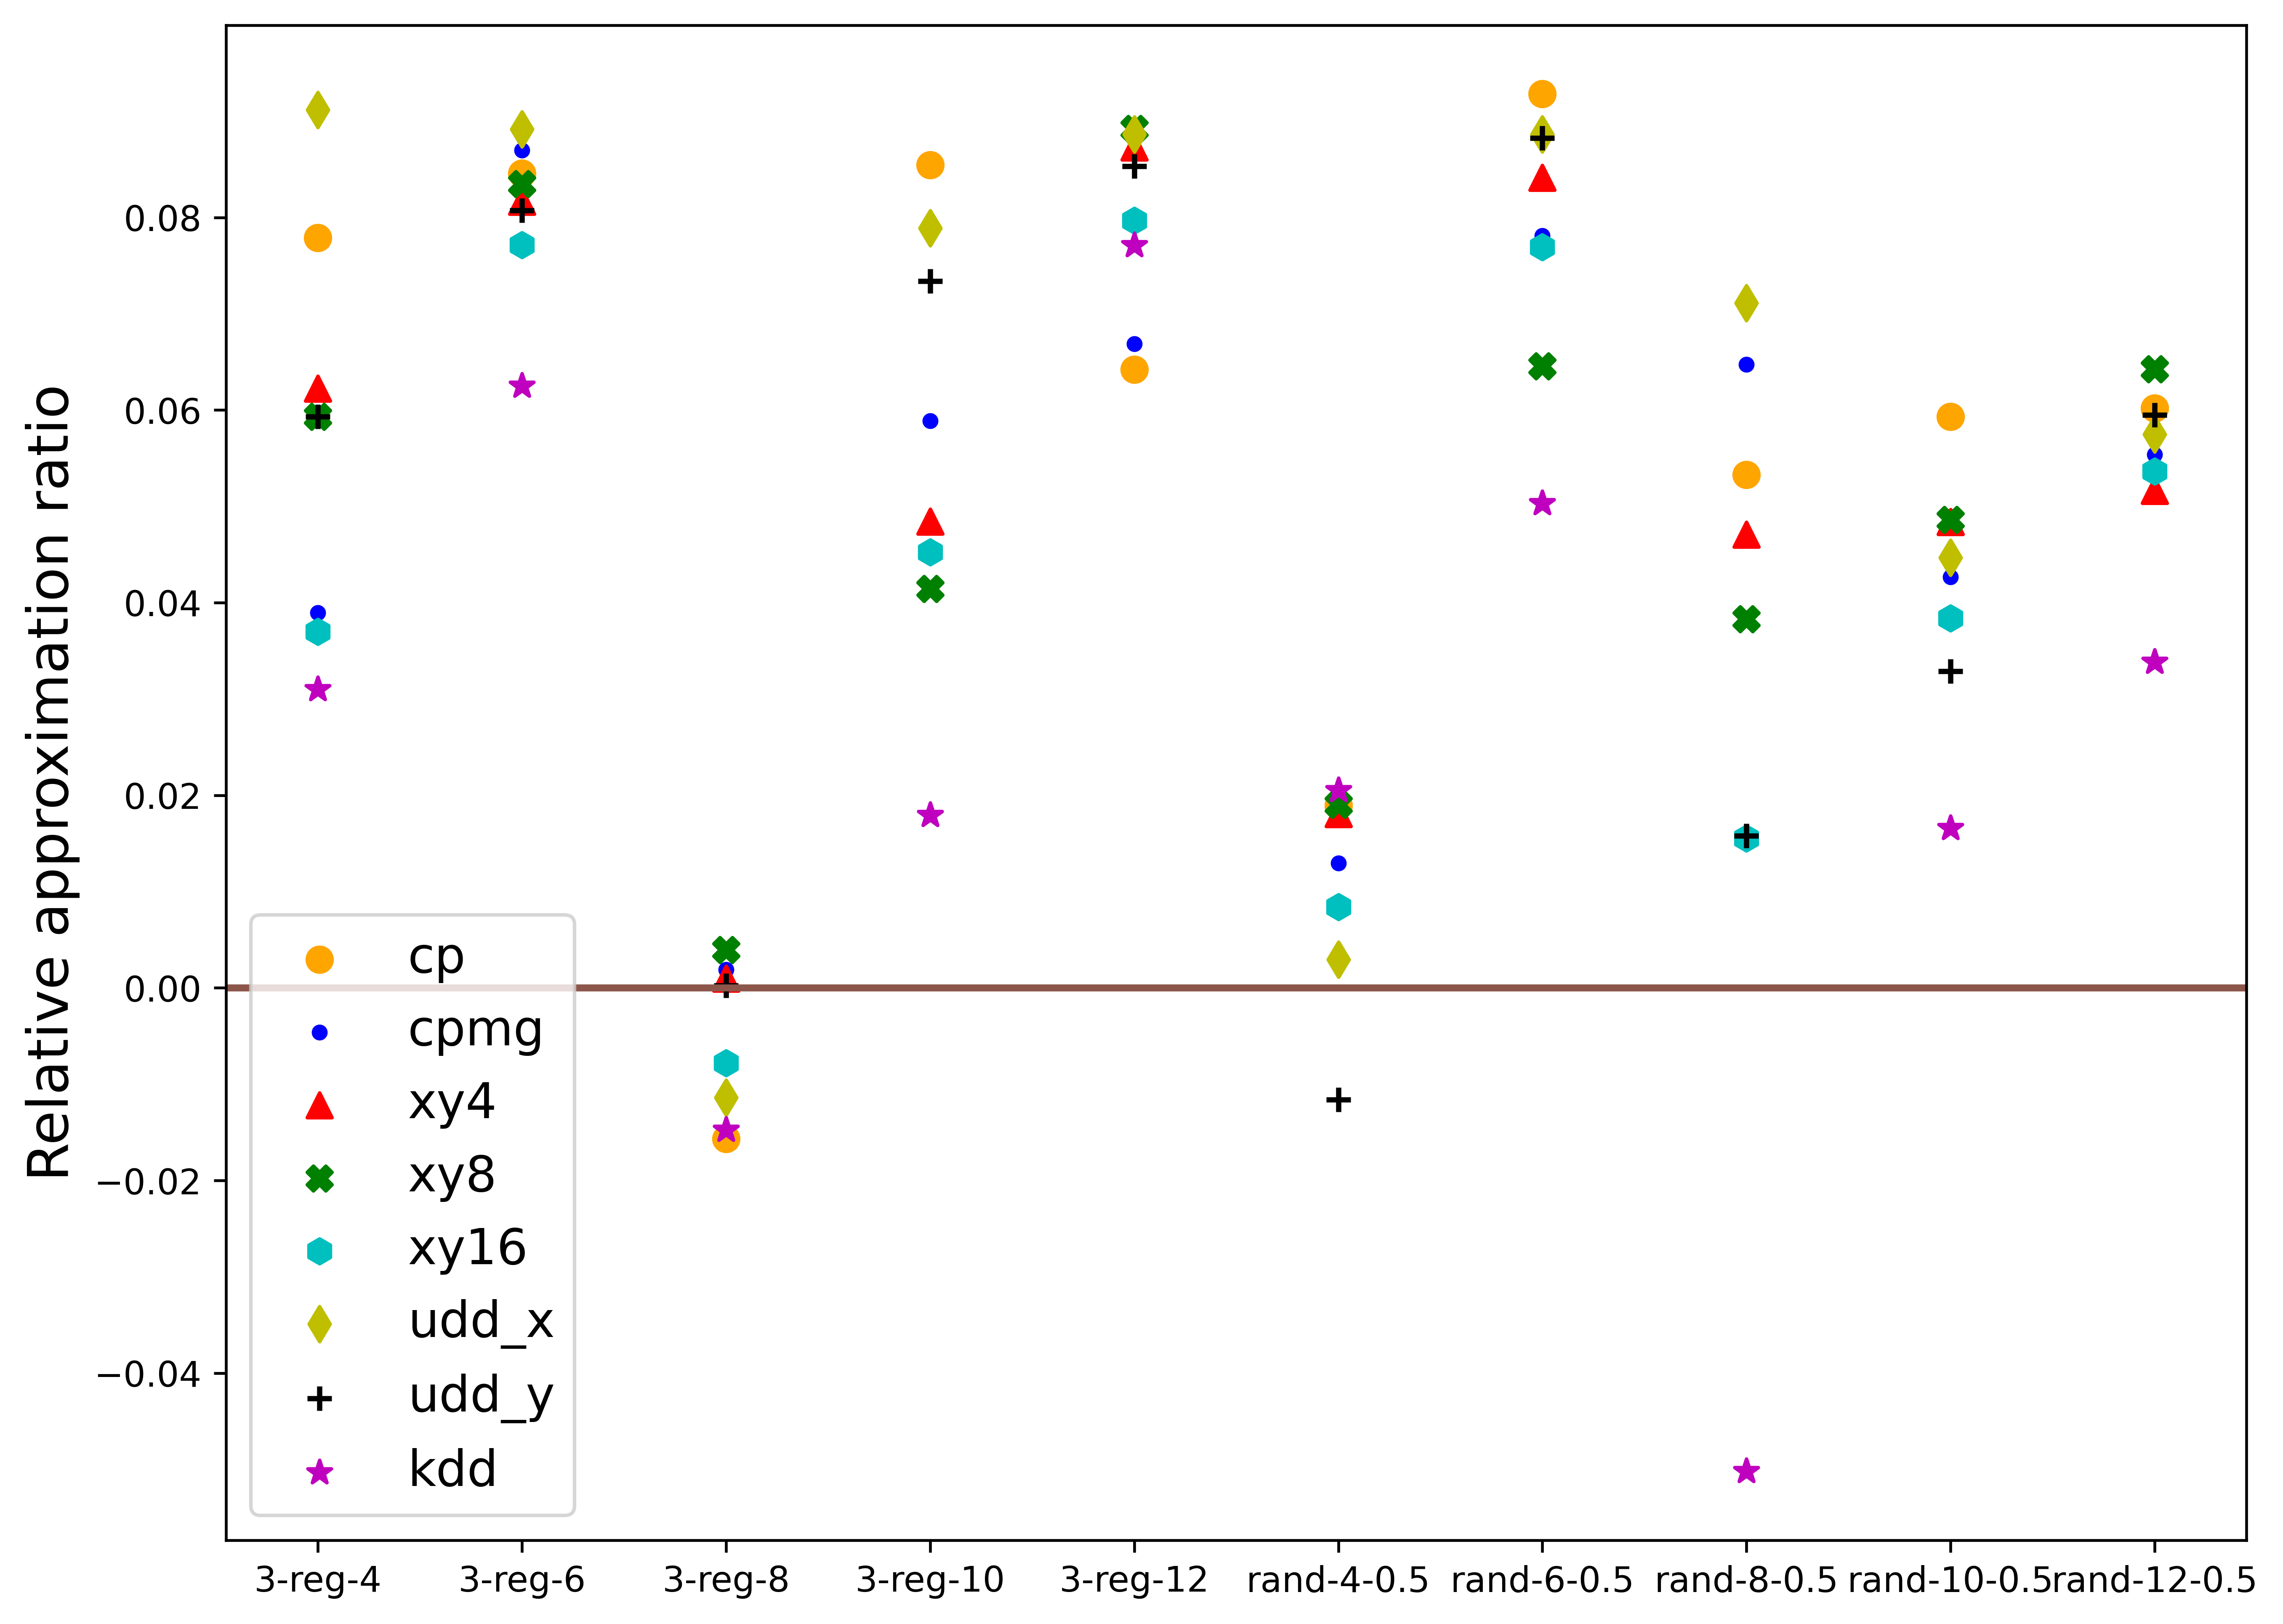

In [17]:
graph_name = ['3-regular-4', '3-regular-6', '3-regular-8', '3-regular-10', '3-regular-12',
              'rand-4-0.5', 'rand-6-0.5', 'rand-8-0.5', 'rand-10-0.5', 'rand-12-0.5',]
import numpy as np
import matplotlib.pyplot as plt
baseline = []

# name = ['Baseline', 'cp', 'cpmgl', 'xy4', 'xy8', 'xy16', 'udd_x_', 'udd_y', 'kdd',
#         'PE', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe','kdd_pe']

data = []
for name in graph_name:
    result_data = results_data[name]
    baseline.append(result_data[0])
    ratio = [i - result_data[0] for i in result_data[1:]]
    data.append(ratio)


data = np.array(data)
# hahn = data[:, 0]
cp = data[:, 2]
cpmg = data[:, 3]
xy4 = data[:, 4]
xy8 = data[:, 5]
xy16 = data[:, 6]
udd_X = data[:, 7]
udd_Y = data[:, 8]
kdd = data[:, 9]

pe = data[:, 10]
# hahn_to = data[:, 10]
cp_pe = data[:, 13]
cpmg_pe = data[:, 14]
xy4_pe = data[:, 15]
xy8_pe = data[:, 16]
xy16_pe = data[:, 17]
udd_X_pe = data[:, 18]
udd_Y_pe = data[:, 19]
kdd_pe = data[:, 20]

graph_name_x = ['3-reg-4', '3-reg-6', '3-reg-8', '3-reg-10', '3-reg-12',
              'rand-4-0.5', 'rand-6-0.5', 'rand-8-0.5', 'rand-10-0.5', 'rand-12-0.5',]
x_ticks = graph_name_x
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

# plt.plot(X, hahn, linestyle='--', marker='o', color='g', label='hahn')
plt.scatter(X, cp, s=50, marker='o', color='orange', label='cp')
plt.scatter(X, cpmg, s=50, marker='.', color='b', label='cpmg')
plt.scatter(X, xy4, s=50, marker='^', color='r', label='xy4')
plt.scatter(X, xy8, s=50, marker='X', color='g', label='xy8')
plt.scatter(X, xy16, s=50, marker='h', color='c', label='xy16')
plt.scatter(X, udd_X, s=50, marker='d', color='y', label='udd_x')
plt.scatter(X, udd_Y, s=50, marker='+', color='k', label='udd_y')
plt.scatter(X, kdd, s=50, marker='*', color='m', label='kdd')
# plt.plot(X, pe, linestyle='--', marker='>', color='c', label='pe')
# # plt.plot(X, hahn_to, linestyle='--', marker='s', color='m', label='hahn_to')
# plt.plot(X, cp_pe, linestyle='--', marker='P', color='tab:pink', label='cp_pe')
# plt.plot(X, cpmg_pe, linestyle='--', marker='h', color='tab:gray', label='cpmg_pe')
# plt.plot(X, xy4_pe, linestyle='--', marker='_', color='tab:purple', label='xy4_pe')
# plt.plot(X, xy8_pe, linestyle='--', marker='<', color='tab:cyan', label='xy8_pe')
# plt.plot(X, xy16_pe, linestyle='--', marker='8', color='lightgreen', label='xy16_pe')
# plt.plot(X, udd_X_pe, linestyle='--', marker='|', color='tab:brown', label='udd_x_pe')
# plt.plot(X, udd_Y_pe, linestyle='--', marker='X', color='tab:olive', label='udd_y_pe')
# plt.plot(X, kdd_pe, linestyle='--', marker='D', color='maroon', label='kdd_pe')

plt.axhline(0, color='tab:brown', lw=2)

plt.legend(loc='best', fontsize=14)
# ax.set_title('Relative approximate ratio with only DD sequences on ibmq_toronto', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks)
ax.set_ylabel('Relative approximation ratio', fontsize=16)

plt.savefig('Relat_AR_toronto_DD_0520_TQE.pdf', bbox_inches='tight', pad_inches=0)

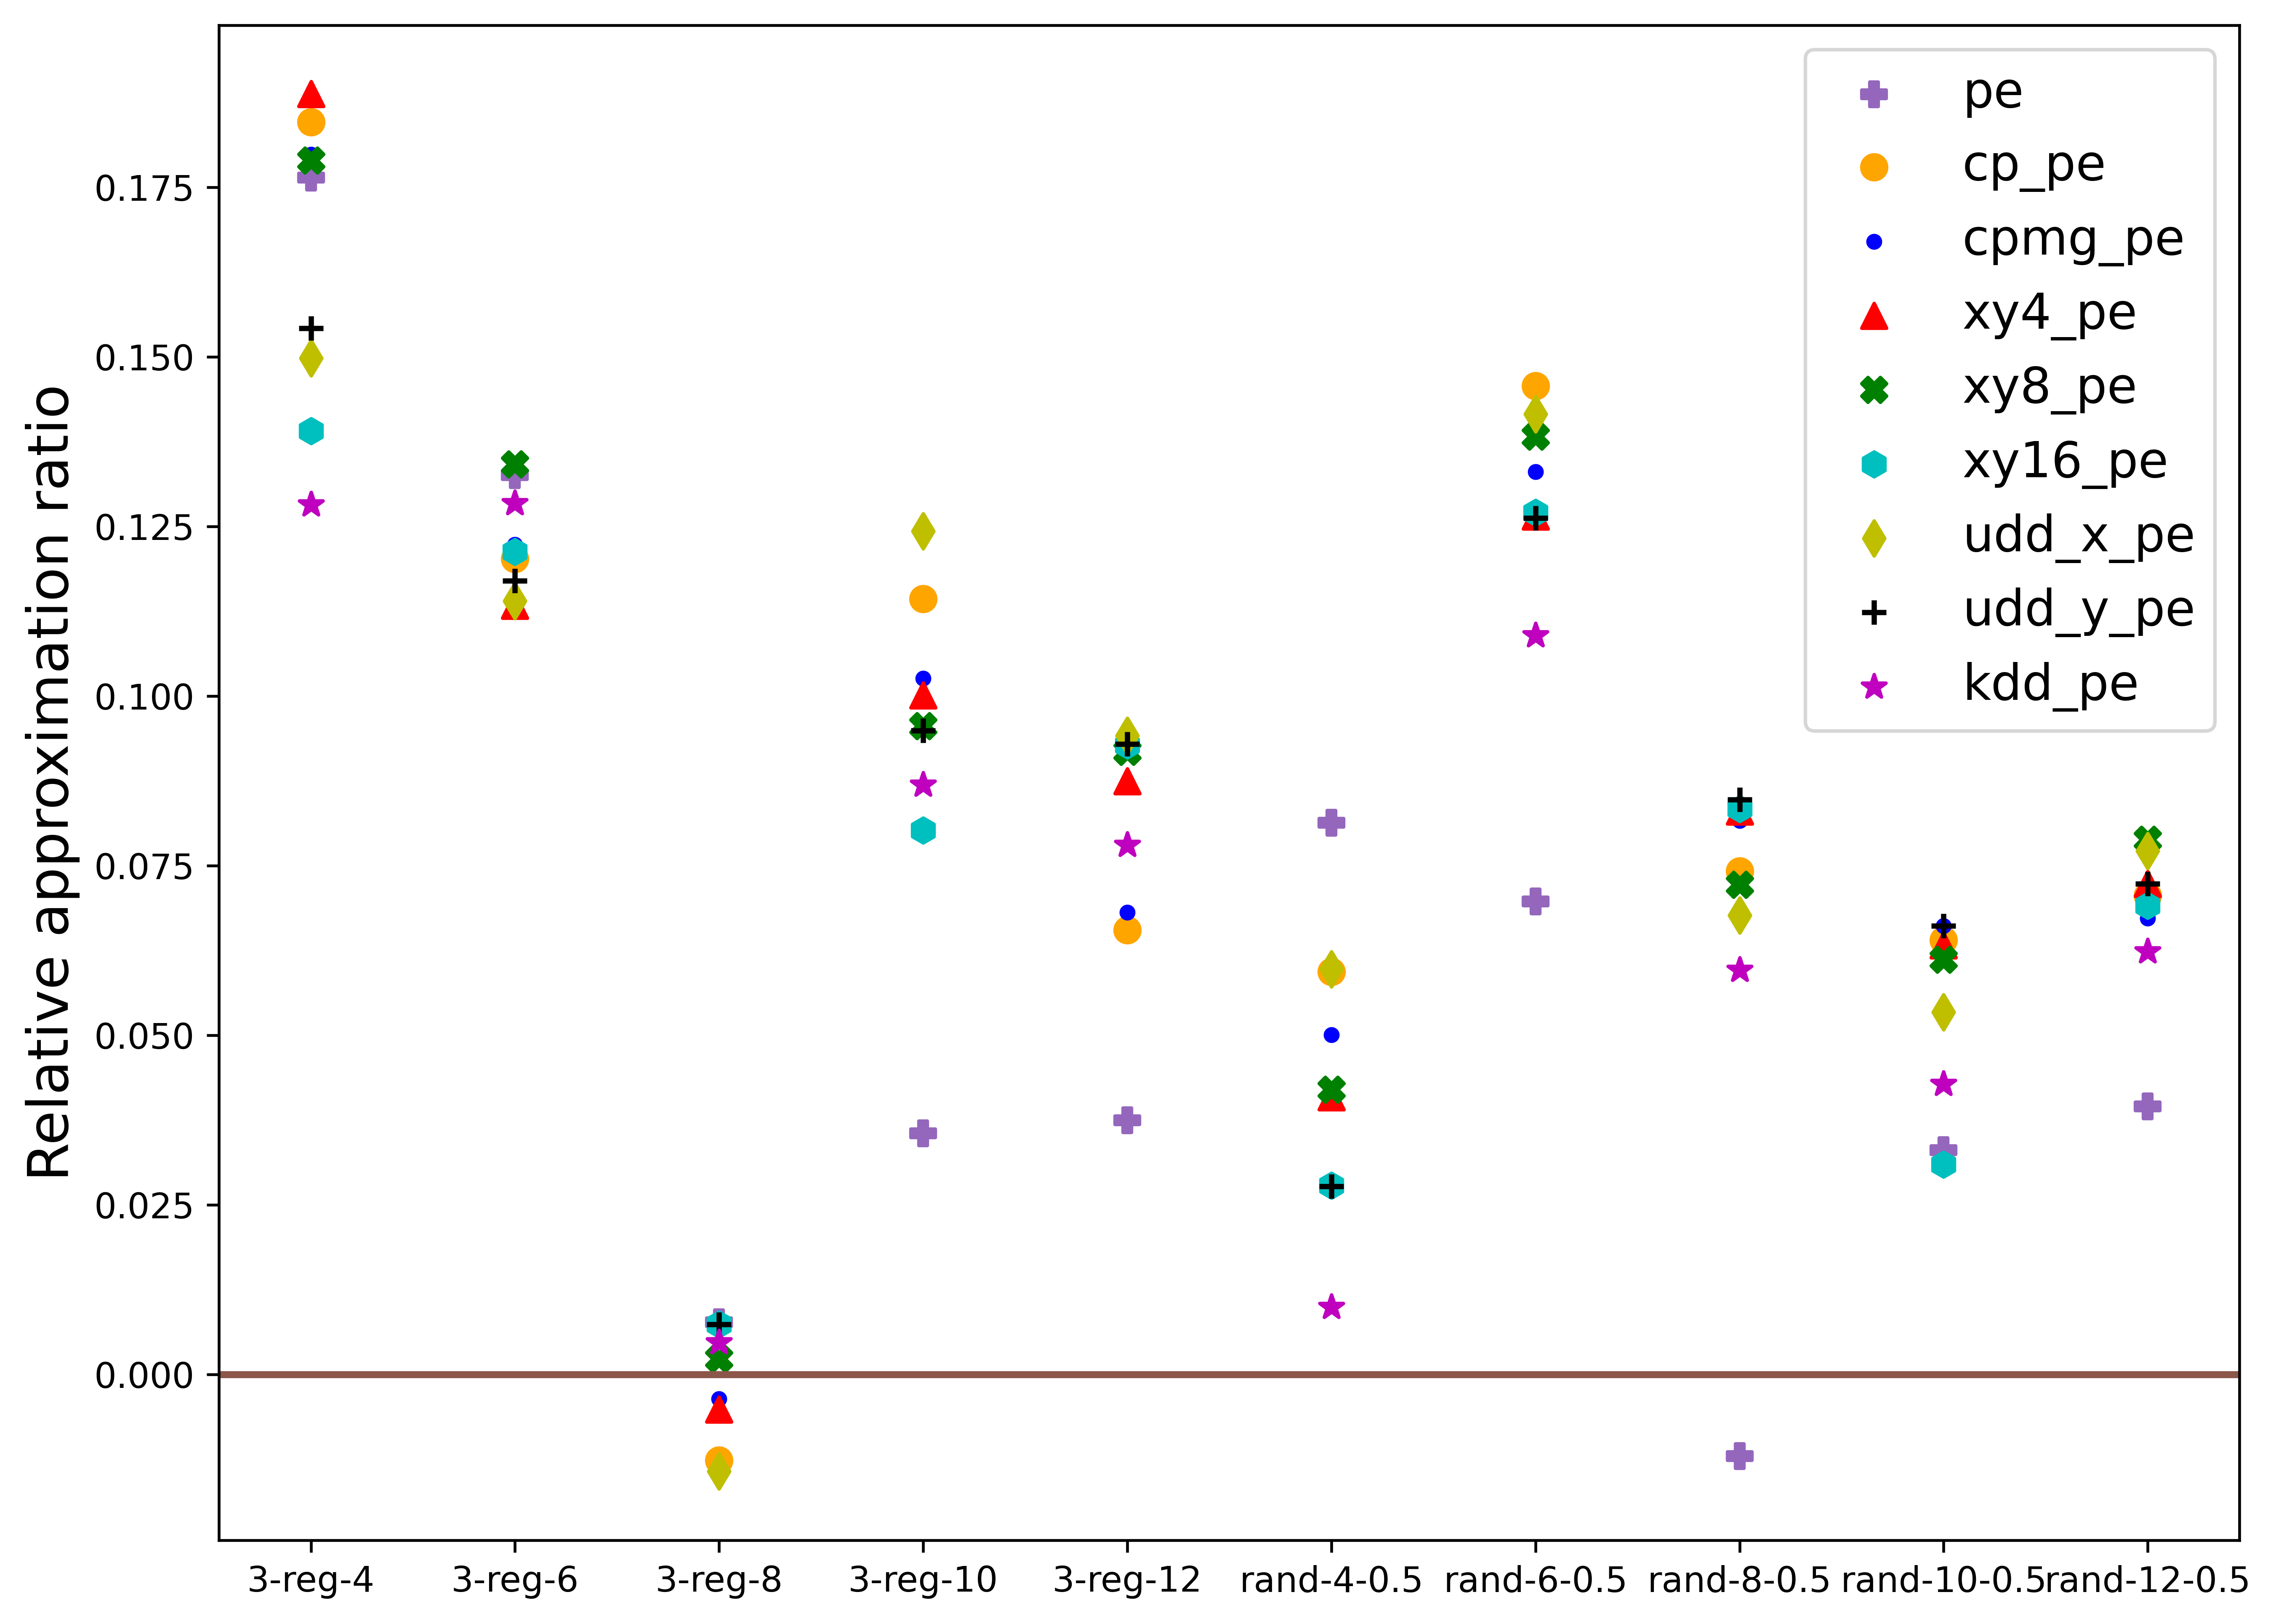

In [18]:

baseline = []

# name = ['Baseline', 'cp', 'cpmgl', 'xy4', 'xy8', 'xy16', 'udd_x_', 'udd_y', 'kdd',
#         'PE', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe','kdd_pe']

data = []
for name in graph_name:
    result_data = results_data[name]
    baseline.append(result_data[0])
    ratio = [i - result_data[0] for i in result_data[1:]]
    data.append(ratio)


data = np.array(data)
# hahn = data[:, 0]
cp = data[:, 2]
cpmg = data[:, 3]
xy4 = data[:, 4]
xy8 = data[:, 5]
xy16 = data[:, 6]
udd_X = data[:, 7]
udd_Y = data[:, 8]
kdd = data[:, 9]

pe = data[:, 10]
# hahn_to = data[:, 10]
cp_pe = data[:, 13]
cpmg_pe = data[:, 14]
xy4_pe = data[:, 15]
xy8_pe = data[:, 16]
xy16_pe = data[:, 17]
udd_X_pe = data[:, 18]
udd_Y_pe = data[:, 19]
kdd_pe = data[:, 20]

graph_name_x = ['3-reg-4', '3-reg-6', '3-reg-8', '3-reg-10', '3-reg-12',
              'rand-4-0.5', 'rand-6-0.5', 'rand-8-0.5', 'rand-10-0.5', 'rand-12-0.5',]
x_ticks = graph_name_x
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

# plt.plot(X, hahn, linestyle='--', marker='o', color='g', label='hahn')
# plt.plot(X, cp, linestyle='--', marker='x', color='orange', label='cp')
# plt.plot(X, cpmg, linestyle='--', marker='.', color='b', label='cpmg')
# plt.plot(X, xy4, linestyle='--', marker='^', color='r', label='xy4')
# plt.plot(X, xy8, linestyle='--', marker='o', color='g', label='xy8')
# plt.plot(X, xy16, linestyle='--', marker='s', color='m', label='xy16')
# plt.plot(X, udd_X, linestyle='--', marker='d', color='y', label='udd_x')
# plt.plot(X, udd_Y, linestyle='--', marker='+', color='k', label='udd_y')
# plt.plot(X, kdd, linestyle='--', marker='v', color='lightcoral', label='kdd')
plt.scatter(X, pe, s=50, marker='P', color='tab:purple', label='pe')
# plt.plot(X, hahn_to, linestyle='--', marker='s', color='m', label='hahn_to')
plt.scatter(X, cp_pe, s=50, marker='o', color='orange', label='cp_pe')
plt.scatter(X, cpmg_pe, s=50, marker='.', color='b', label='cpmg_pe')
plt.scatter(X, xy4_pe, s=50, marker='^', color='r', label='xy4_pe')
plt.scatter(X, xy8_pe, s=50, marker='X', color='g', label='xy8_pe')
plt.scatter(X, xy16_pe, s=50, marker='h', color='c', label='xy16_pe')
plt.scatter(X, udd_X_pe, s=50, marker='d', color='y', label='udd_x_pe')
plt.scatter(X, udd_Y_pe, s=50, marker='+', color='k', label='udd_y_pe')
plt.scatter(X, kdd_pe, s=50, marker='*', color='m', label='kdd_pe')

plt.axhline(0, color='tab:brown', lw=2)

plt.legend(loc='best', fontsize=14)
# ax.set_title('Relative approximate ratio with DD sequences+pulse efficient on ibmq_toronto', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks)
ax.set_ylabel('Relative approximation ratio', fontsize=16)

plt.savefig('Relat_AR_toronto_DD_pe_0520_TQE.pdf', bbox_inches='tight', pad_inches=0)

In [25]:
name = ['Original_ideal', 'hahn_X_ideal', 'hahn_Y_ideal', 'cp_ideal', 'cpmg_ideal', 'xy4_ideal', 'xy8_ideal', 'xy16_ideal', 'udd_x_ideal', 'udd_y_ideal', 'KDD_ideal',
        'Original_pe', 'hahn_X_pe', 'hahn_Y_pe', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe', 'KDD_pe']
for i in range(2,21):
    print(name[i+1], data[:,i])
    print('average of improvement:',sum(data[:,i])/len(data[:,i]))
    print('----')

cp_ideal [ 0.07788086  0.08457031 -0.01568604  0.08544922  0.06420898  0.0189209
  0.09281413  0.05330404  0.05930398  0.06018066]
average of improvement: 0.05809470436789773
----
cpmg_ideal [0.03894043 0.08696289 0.00189209 0.05888228 0.06689453 0.01293945
 0.07808431 0.06472439 0.04265803 0.0553894 ]
average of improvement: 0.05073678064827967
----
xy4_ideal [0.06225586 0.08164062 0.00097656 0.04845082 0.08729771 0.01806641
 0.08414714 0.04709201 0.04840643 0.05163574]
average of improvement: 0.05299693009898088
----
xy8_ideal [0.05932617 0.08349609 0.00393677 0.04145952 0.08921596 0.01904297
 0.0645752  0.03830295 0.04860618 0.0642395 ]
average of improvement: 0.051220130645179475
----
xy16_ideal [ 0.0369873   0.07714844 -0.0078125   0.04525479  0.0796596   0.00842285
  0.0769043   0.01554362  0.03839666  0.0536499 ]
average of improvement: 0.04241549669406115
----
udd_x_ideal [ 0.09118652  0.08916016 -0.01138306  0.07887962  0.08862305  0.00292969
  0.08862305  0.07109918  0.044655

In [21]:
np.max(data)

0.1939697265625

In [27]:
#only DD max value
np.max(data[:,2:10])

0.09281412760416669

In [28]:
(0.1939697265625-0.09281412760416669)/0.09281412760416669

1.0898728627794823